Category 	Available 	Requirements
Total Points 	100	
Create Models	50	Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 
Model Advantages	10	Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
Interpret Feature Importance	30	Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
Interpret Support Vectors	10	Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

1. You must include all of your data wrangling code, if you want to receive full credit.  Otherwise, your work is not reproducible.  This is true for all submissions. You are the only group who left this out. I need to see what you started with and all transformations. The dataset must still meet the minimum size after all transformations.  I will not accept future labs without this code included.  

2. I have stated multiple times that the minimum dataset size is 15 columns x 30,000 rows = 450,000 elements. My feedback clearly states that what you submitted is currently at 16 * 9731 = 155,696 elements. As I said in the feedback: "In future labs, you will need to increase the number of fields you use for modeling to achieve at least 15 * 30,000 = 450,000 elements.". 

3. Unfortunately for Lab 1, it really makes no difference what your yearly tables may look like at this point, because they were not included in your submission? 

4. I see above that the dataset you produced for each year has many more fields / columns / features that you could have included to meet the minimum size requirements?  The starting point should have likely been that entire dataset.  I am also slightly concerned about your statement that "merging is a simple inner join activity" for a number of reasons. The dataset you started with does not appear to be joined at all.  There is a year column in the dataset.  This gives me the impression that you actually unioned the data by year (which is what I would have expected). However, I really have no clue what you did, because you chose not to share that with me.

Thoughts on inner joining this data:
A number of public school campuses open and close each school year.  If you are joining by unit_code / agency_code, your analysis will only include school campuses open during the entire duration of the data.
Any classification model you create in a "joined" dataset will likely have duplicated columns for each year.  This means that the feature importances for the model will be dominated by prior years.  For example, if you build a model to predict graduation rates, the model will use all prior year's graduation rates for the prediction.  It will also be very accurate.  However, I am not sure what benefit such a model would provide to the public school system?
Typically, you would not include any graduation rate features in your graduation rate model training data at all. (we can talk about this more, if needed).      

# MiniLab SVM and Logistic Regression
#### 06/14/2020
#### Yang Zhang, Reannan McDaniel, Jonathon Roach, Fred Poon

## Data Preparation

### Background

For this analysis, our group start with the dataset from Lab1. The dataset contains North Carolina Public Schools Report Card and Statistical Profiles Data sets from the years 2014 to 2017. Currently there are 9371 records with 289 variables in this data. The preparation procedure to get to this dataset from original tables are located here:

Script to process the dataset 2014 to 2019 seperately 
https://github.com/fredpoon/ds_7331_jyrf_eda/blob/master/Data_Prep/PublicSchools2014to2019_MLnew.ipynb

Script to merge 2014 to 2017 datasets together
https://github.com/fredpoon/ds_7331_jyrf_eda/blob/master/Data_Prep/PublicSchools2014to2019_MLnew_merge.ipynb

In the starting dataset, all the categoricial variables are stored as "object". In order to be able to utilize it in our machine learning model, we conduct a one-hot encoding procedure to convert all of them into continuous variables. The procedure is shown below.

The construction of code chunk is referred to Dr. Drew's github repository, [https://github.com/jakemdrew/EducationDataNC](https://github.com/jakemdrew/EducationDataNC/tree/master/Data%20Documentation)

### One-Hot Encoding

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For multiple line outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

schoolData = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/PublicSchools2014to2017_YZ.csv') # read in the csv file

In [120]:
#Locate the categorical variables in dataset
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
uniqueThreshold = 25

#Delete categorical columns with > 25 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = schoolData[sD_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
schoolData.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

#Review dataset contents one hot high unique value drops
print('*********After: Removing columns with >= uniqueThreshold unique values***********')
schoolData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(oneHotUniqueValueCols))

*********After: Removing columns with >= uniqueThreshold unique values***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 250 entries, szip_ad to Year
dtypes: float64(237), int64(2), object(11)
memory usage: 18.6+ MB

Columns Deleted:  9


"SPG Grade" is our response variable and "SPG Score" is the continous expression of it. We have to remove them from the original dataset.

In [121]:
#Keep an original copy of the Data
schoolData_org = schoolData

#Pop out the SPG information from the Data
schoolData_SPG = schoolData.pop('SPG Grade')
schoolData_SPGScore = schoolData.pop('SPG Score')

In [122]:
schoolData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 248 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   szip_ad                              float64
 1   category_cd                          object 
 2   calendar_type_txt                    object 
 3   sna_pgm_type_cd                      object 
 4   school_type_txt                      object 
 5   calendar_only_txt                    object 
 6   title1_type_cd                       object 
 7   esea_status                          object 
 8   student_num                          float64
 9   lea_avg_student_num                  float64
 10  st_avg_student_num                   float64
 11  Grad_project_status                  object 
 12  Math I_Size                          float64
 13  lea_total_expense_num                float64
 14  lea_salary_expense_pct               float64
 15  lea_services_expense_pct             

We also need to get rid of all the columns that directly used to calculate SPG Grade and Score. 
(Expand it)
For example: EOG_XXX, EOC_XXX.

After removing them, we display the information of the variables to make sure we don't have them in the dataset anymore.

In [123]:
# Remove All the Columns that directly used to calculate SPG Grade and Score
schoolData.drop(schoolData.iloc[:, 22:162], inplace=True, axis=1)
schoolData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 108 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   szip_ad                              float64
 1   category_cd                          object 
 2   calendar_type_txt                    object 
 3   sna_pgm_type_cd                      object 
 4   school_type_txt                      object 
 5   calendar_only_txt                    object 
 6   title1_type_cd                       object 
 7   esea_status                          object 
 8   student_num                          float64
 9   lea_avg_student_num                  float64
 10  st_avg_student_num                   float64
 11  Grad_project_status                  object 
 12  Math I_Size                          float64
 13  lea_total_expense_num                float64
 14  lea_salary_expense_pct               float64
 15  lea_services_expense_pct             

The below procedure do the one-hot encoding for the left categorical variable. As shown below we have a total of 20 categorical variables to encode and we end up with 40 variables after the encoding process.

In [124]:
#Isolate remaining categorical variables
begColumnCt = len(schoolData.columns)

#one hot encode categorical variables
schoolData = pd.get_dummies(data=schoolData,drop_first=True)

In [125]:
#Determine change in column count
endColumnCt = len(schoolData.columns)
columnsAdded = endColumnCt - begColumnCt


#Review dataset contents one hot high unique value drops
print('Columns To One-Hot Encode: ', len(sD_nominal.columns))
print('\r\n*********After: Adding New Columns Via One-Hot Encoding*************************')
schoolData.info(verbose=False)
print ('\r\nNew Columns Created Via One-Hot Encoding: ', columnsAdded)

Columns To One-Hot Encode:  20

*********After: Adding New Columns Via One-Hot Encoding*************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 148 entries, szip_ad to Category_Cd_T
dtypes: float64(96), int64(2), uint8(50)
memory usage: 7.7 MB

New Columns Created Via One-Hot Encoding:  40


A dimension check of the dataset after the one-hot encoding process shows that we have a total of 9371 records with 148 seperate variables. All of the variables are in numerical format now.

In [126]:
# Dimension of Dataset
schoolData.shape

schoolData.head()

(9731, 148)

,szip_ad,student_num,lea_avg_student_num,st_avg_student_num,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,lea_instruct_equip_exp_pct,...,Grad_project_status_Y,EVAAS Growth Status_Exceeded,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,Category_Cd_A,Category_Cd_E,Category_Cd_H,Category_Cd_I,Category_Cd_M,Category_Cd_T
0,27253.0,78.0,954.0,837.0,0.0,8028.59,0.613,0.078,0.086,0.011,...,0,0,0,0,0,0,1,0,0,0
1,27253.0,539.0,518.0,496.0,0.0,8028.59,0.613,0.078,0.086,0.011,...,0,1,0,0,0,1,0,0,0,0
2,27244.0,547.0,518.0,496.0,0.0,8028.59,0.613,0.078,0.086,0.011,...,0,0,1,0,0,1,0,0,0,0
3,27217.0,800.0,768.0,665.0,26.0,8028.59,0.613,0.078,0.086,0.011,...,0,0,0,1,0,0,0,0,1,0
4,27215.0,664.0,518.0,496.0,0.0,8028.59,0.613,0.078,0.086,0.011,...,0,1,0,0,0,1,0,0,0,0


### Feature Selection

We original have 148 features in the data table. We don't want to include this many features for model feasibility. However, as we have a data size requirement, and we also want the constructing model to be high quality. We decide to conduct a feature selection process to choose the most important features to use.

There are many ways to conduct feature selection. In this project we use random forest and plot out feature importances of all features. The work below is not for feasible model construction (we didn't split train/test) but just for picking out the most important variables to use.  

In [127]:
# Random Forest apply to X with all variables
from sklearn.ensemble import RandomForestClassifier
clfa=RandomForestClassifier(n_estimators=100)
clfa.fit(schoolData,schoolData_SPG)
y_pred=clfa.predict(schoolData)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy = 1.0 does not surprise us because we didn't to train/test splitting. 

In [128]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(schoolData_SPG, y_pred))

Accuracy: 1.0


Below plot reflect what features are important and their according weights.

In [129]:
#For feature importance
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clfa, random_state=1).fit(schoolData,schoolData_SPG)
eli5.show_weights(perm, feature_names = schoolData.columns.tolist(), top=50)

Weight,Feature
0.0362 ± 0.0018,TotalTargets_pTarget_PctMet
0.0134 ± 0.0010,EVAAS Growth Status_NotMet
0.0041 ± 0.0008,MinorityFemalePct
0.0030 ± 0.0005,MinorityMalePct
0.0020 ± 0.0004,short_susp_per_c_num
0.0013 ± 0.0003,AsianFemalePct
0.0007 ± 0.0003,BlackMalePct
0.0006 ± 0.0001,avg_daily_attend_pct
0.0004 ± 0.0003,title1_type_cd_Y
0.0004 ± 0.0002,EVAAS Growth Status_Exceeded


To meet the data size requirement, we need to have as least 450,000/9371 = 48 variables to use for the data. 

To satisfy this we pick the first 50 variables to use. Notice that in the below variable list there are both continuous variables and the categorical variables after one-hot encoding. 

In [130]:
#Pick and Choose variables
schoolData_pick = schoolData[[
'TotalTargets_pTarget_PctMet',
'EVAAS Growth Status_NotMet',
'MinorityMalePct',
'MinorityFemalePct',
'title1_type_cd_Y',
'avg_daily_attend_pct',
'short_susp_per_c_num',
'BlackMalePct',
'AsianFemalePct',
'student_num',
'HispanicMalePct',
'SciGr5&8_pTarget_PctMet',
'tchyrs_0thru3_pct',
'tchyrs_11plus_pct',
'Accomplished_TCHR_Standard 2_Pct',
'Accomplished_TCHR_Standard 1_Pct',
'Developing_TCHR_Standard 1_Pct',
'Developing_TCHR_Standard 2_Pct',
'Developing_TCHR_Standard 3_Pct',
'Accomplished_TCHR_Standard 4_Pct',
'4-10 Years_LEA_Exp_Pct_Prin',
'Developing_TCHR_Standard 4_Pct',
'Developing_TCHR_Standard 5_Pct',
'10+ Years_LEA_Exp_Pct_Prin',
'Accomplished_TCHR_Standard 3_Pct',
'Accomplished_TCHR_Standard 5_Pct',
'lea_state_perpupil_num',
'st_emer_prov_teach_pct',
'pct_GCE_ALL',
'MathGr3-8_pTarget_PctMet',
'lea_sat_avg_score_num',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'nbpts_num',
'Distinguished_TCHR_Standard 2_Pct',
'_1yr_tchr_trnovr_pct',
'lateral_teach_pct',
'0-3 Years_LEA_Exp_Pct_Prin',
'lea_flicensed_teach_pct',
'lea_tchyrs_4thru10_pct',
'lea_tchyrs_11plus_pct',
'lea_nbpts_num',
'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct',
'lea_emer_prov_teach_pct',
'st_flicensed_teach_pct',
'st_tchyrs_0thru3_pct',
'st_1yr_tchr_trnovr_pct',
'lea_tchyrs_0thru3_pct',
'Category_Cd_T',
]]

# Dataset Dimension with picked variables
schoolData_pick.shape

(9731, 50)

### Training/Testing Splitting

To prepare our official SVM and Logistic regression modeling procedure, we need to split the dataset into training and testing set. We use the ShuffleSplit criteria below. We use a proportion of 80/20 for the training/testing dataset.

In [131]:
# Using ShuffleSplit for Training/Testing Split 
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 3
num_instances = len(schoolData_SPG)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [132]:
# Split X and Y into Training and Testing dataset
for train_indices, test_indices in cv_object.split(schoolData_pick,schoolData_SPG): 

    Xsel_train = schoolData_pick.values[train_indices]
    ysel_train = schoolData_SPG.values[train_indices]
    Xall_train = schoolData.values[train_indices]
    
    Xsel_test = schoolData_pick.values[test_indices]
    ysel_test = schoolData_SPG.values[test_indices]
    Xall_test = schoolData.values[test_indices]

 With our feature selection (51 variables), check and make sure it contains most information. The way we conduct the validation is by running another random forest and check the accuracy. This accuracy of the current model (acc=0.733) is close to the model utilizing all the variables (acc=0.736). So we varify that our selection is reasonable.

In [133]:
# Random Forest fitting with selective variables
clf_rf=RandomForestClassifier(n_estimators=100)
clf_rf.fit(Xsel_train,ysel_train)
y_pred_rf=clf_rf.predict(Xsel_test)

# Random Forest fitting with all variables
clf_rf_all=RandomForestClassifier(n_estimators=100)
clf_rf_all.fit(Xall_train,ysel_train)
y_pred_rf_all=clf_rf_all.predict(Xall_test)

print("Model with Selective Variables Accuracy:",metrics.accuracy_score(ysel_test, y_pred_rf))
print("Model with All Variables Accuracy:",metrics.accuracy_score(ysel_test, y_pred_rf_all))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Model with Selective Variables Accuracy: 0.7426810477657936
Model with All Variables Accuracy: 0.7498715973292245


### Solving Data Imbalance

We find that our response variable (SPG_Grade) has a data balancing problem: The grade C is dominate the dataset with the largest propertion, followed by B or D. A and F are just a small propertion of the whole dataset. 

First we investigate the current class of the SPG Grade and found that the class "A" and "A+NG" are identical so we merge the two, the class "I" has incomplete information so we are removing it from the dataset.

In [145]:
#schoolData_SPG_org = schoolData_SPG
schoolData_SPG = schoolData_SPG_org

import numpy as np
schoolData_SPG= np.select(
    [
        schoolData_SPG == 'A', 
        schoolData_SPG == 'B',
        schoolData_SPG == 'C',
        schoolData_SPG == 'D',
        schoolData_SPG == 'F',
        schoolData_SPG == 'A+NG',
        schoolData_SPG == 'I'
    ], 
    [
        'A', 
        'B',
        'C',
        'D',
        'F',
        'A',
        'NA'
    ],
    default='NA'
)

#Filter out the sample with "NA" on SPG Grade
schoolData_SPG_new = schoolData_SPG[schoolData_SPG!='NA']
schoolData_pick_new = schoolData_pick[schoolData_SPG!='NA']

# Check if the levels of SPG Grade has been altered
s = pd.DataFrame(schoolData_SPG_new)
s.describe()

,0
count,9216
unique,5
top,C
freq,3973


After merging the class, we can see below a distribution of current SPG Grade. The grade C is dominate the dataset with the largest propertion, followed by B or D. A and F are just a small propertion of the whole dataset. We need to re-balance the data.

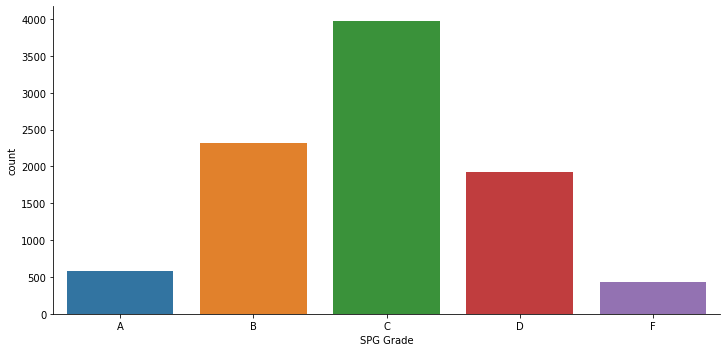

In [75]:
#Factor Plot for SPG Grade
s.columns=['SPG Grade']
                        
sns.factorplot("SPG Grade", data=s, aspect=2,
                       kind="count", order=['A','B','C','D','F'])

plt.show()

To solve this problem, we are using the crieteria below.

#### Test 3 types of sampler: UnderSample all cases, UnderSample majority class, SMOTE Oversample

Below we conduct 3 seperate procedures to produce 3 seperate sets of X and y from the original dataset. Those sets will be evaluate against each other and we will decide the best data balancing strategy to use.

In [82]:
# Check the dimension for X and y
schoolData_pick_new.shape
schoolData_SPG_new.shape

(9216, 50)

(9216,)

In [91]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the dataset using the RandomUnderSampler 
# Set all class sizes equal to the smallest class.
us = RandomUnderSampler()
X_us, y_us = us.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

# Plot the new class distributions for y using the same funnction as above. 
#plot_class_dist(y_us)

In [93]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the dataset using the RandomUnderSampler 
# Undersample the majority class only
us = RandomUnderSampler(sampling_strategy='majority')
X_us_maj, y_us_maj = us.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

# Plot the new class distributions for y using the same funnction as above. 
#plot_class_dist(y_us_maj)

In [94]:
from imblearn.over_sampling import SMOTE

# Oversample using SMOTE
# Make all classes the same size as the majority class.
# WARNING - This can exponentially increase the size of the input dataset.
sm = SMOTE(sampling_strategy='not majority')
X_sm, y_sm = sm.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

# Plot the new class distributions for y using the same funnction as above. 
#plot_class_dist(y_sm)

By comparing the results for the 3 different methods dealing with data imbalance, we run random forest with the datasets we generated. Accuracy are measured with the results of the variables. As shown the SMOTE strategy get the highest accuracy. It will be used for the later SVM and Logistic regression fitting.

In [92]:
#Training using Undersample Method1 
for train_indices, test_indices in cv_object.split(X_us,y_us): 

    X_train = X_us.values[train_indices]
    y_train = y_us.values[train_indices]
    
    X_test = X_us.values[test_indices]
    y_test = y_us.values[test_indices]
    

clfus=RandomForestClassifier(n_estimators=100)
clfus.fit(X_train,y_train)
y_pred_us=clfus.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_us))

C:\Users\taniat470s\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.6767441860465117


In [95]:
#Training using Undersample Method2
for train_indices, test_indices in cv_object.split(X_us_maj,y_us_maj): 

    X_train = X_us_maj.values[train_indices]
    y_train = y_us_maj.values[train_indices]
    
    X_test = X_us_maj.values[test_indices]
    y_test = y_us_maj.values[test_indices]
    
clfusm=RandomForestClassifier(n_estimators=100)
clfusm.fit(X_train,y_train)
y_pred_usm=clfusm.predict(X_test)
    
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_usm))

C:\Users\taniat470s\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.8044052863436123


In [96]:
#Training using Oversample Method
for train_indices, test_indices in cv_object.split(X_sm,y_sm): 

    X_train = X_sm.values[train_indices]
    y_train = y_sm.values[train_indices]
    
    X_test = X_sm.values[test_indices]
    y_test = y_sm.values[test_indices]

clfsm=RandomForestClassifier(n_estimators=100)
clfsm.fit(X_train,y_train)
y_pred_sm=clfsm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sm))

C:\Users\taniat470s\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.8887490561288699


## Model Creation
### SVM Work


First, let's split the original dataset (with No SMOTE balancing) to train/test, and do SVM.

In [151]:
# Split X and Y into Training and Testing dataset
for train_indices, test_indices in cv_object.split(schoolData_pick_new,schoolData_SPG_new): 

    Xsel_train = schoolData_pick_new.values[train_indices]
    ysel_train = schoolData_SPG_new[train_indices]
    
    Xsel_test = schoolData_pick_new.values[test_indices]
    ysel_test = schoolData_SPG_new[test_indices]

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scl_obj = StandardScaler()

Xorg_train_scaled = scl_obj.fit_transform(Xsel_train) # apply to training
Xorg_test_scaled = scl_obj.fit_transform(Xsel_test) 

In [154]:
%%time
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn import metrics as mt

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(Xorg_train_scaled, ysel_train)  # train object

y_hat = svm_clf.predict(Xorg_test_scaled) # get test set precitions

acc = mt.accuracy_score(ysel_test,y_hat)
conf = mt.confusion_matrix(ysel_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7066160520607375
[[ 57  51   2   0   0]
 [ 14 317 142   4   0]
 [  1  70 653  68   1]
 [  0   0 123 266   1]
 [  0   0   2  62  10]]
Wall time: 5.38 s


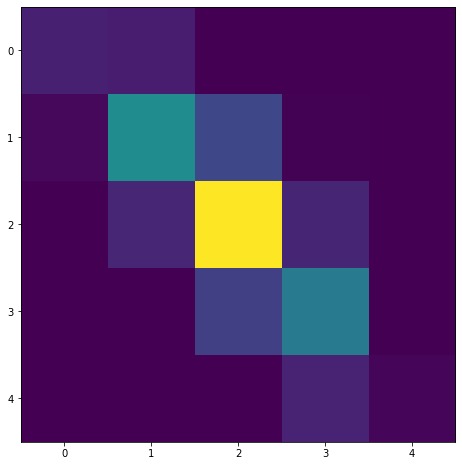

In [155]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)

The accuracy for the above model is around 70%. However the confusion matrix shows that because the data is imbalance, the accuracy across different class are a lot different from each other. For example, the accuracy rate of C is much higher than other class.

Below we are using the SMOTE balanced dataset for SVM work:

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scl_obj = StandardScaler()

Xs2_train_scaled = scl_obj.fit_transform(X_train) # apply to training
Xs2_test_scaled = scl_obj.fit_transform(X_test) 

In [101]:
%%time
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn import metrics as mt

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(Xs2_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(Xs2_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

C:\Users\taniat470s\Anaconda3\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.8255726151522779
[[751  26   7   0   0]
 [ 81 597  91   8   1]
 [  1 115 559  99   3]
 [  0   5 113 607  75]
 [  0   2   3  63 766]]
Wall time: 22.6 s


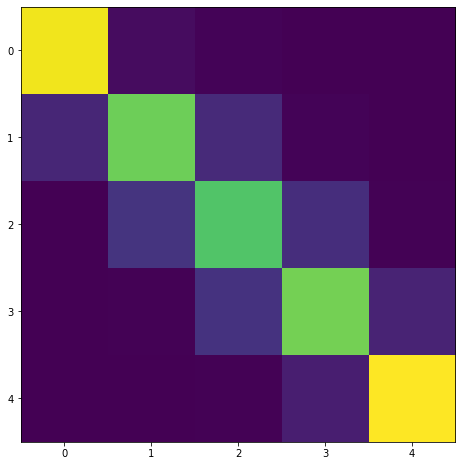

In [103]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)

In [102]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(10583, 50)
(10583,)
[1239 2528 2803 2629 1384]


*********
****I am re-assigning colnames for plotting, let me know if you have a better way to do that.

In [104]:
schoolData_sm = pd.DataFrame(X_sm)
schoolData_sm.columns=['TotalTargets_pTarget_PctMet',
'EVAAS Growth Status_NotMet',
'MinorityMalePct',
'MinorityFemalePct',
'title1_type_cd_Y',
'avg_daily_attend_pct',
'short_susp_per_c_num',
'BlackMalePct',
'AsianFemalePct',
'student_num',
'HispanicMalePct',
'SciGr5&8_pTarget_PctMet',
'tchyrs_0thru3_pct',
'tchyrs_11plus_pct',
'Accomplished_TCHR_Standard 2_Pct',
'Accomplished_TCHR_Standard 1_Pct',
'Developing_TCHR_Standard 1_Pct',
'Developing_TCHR_Standard 2_Pct',
'Developing_TCHR_Standard 3_Pct',
'Accomplished_TCHR_Standard 4_Pct',
'4-10 Years_LEA_Exp_Pct_Prin',
'Developing_TCHR_Standard 4_Pct',
'Developing_TCHR_Standard 5_Pct',
'10+ Years_LEA_Exp_Pct_Prin',
'Accomplished_TCHR_Standard 3_Pct',
'Accomplished_TCHR_Standard 5_Pct',
'lea_state_perpupil_num',
'st_emer_prov_teach_pct',
'pct_GCE_ALL',
'MathGr3-8_pTarget_PctMet',
'lea_sat_avg_score_num',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'nbpts_num',
'Distinguished_TCHR_Standard 2_Pct',
'_1yr_tchr_trnovr_pct',
'lateral_teach_pct',
'0-3 Years_LEA_Exp_Pct_Prin',
'lea_flicensed_teach_pct',
'lea_tchyrs_4thru10_pct',
'lea_tchyrs_11plus_pct',
'lea_nbpts_num',
'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct',
'lea_emer_prov_teach_pct',
'st_flicensed_teach_pct',
'st_tchyrs_0thru3_pct',
'st_1yr_tchr_trnovr_pct',
'lea_tchyrs_0thru3_pct',
'Category_Cd_T',
]

In [114]:
y_sm.values[svm_clf.support_] 

array([['C'],
       ['C'],
       ['C'],
       ...,
       ['D'],
       ['D'],
       ['D']], dtype=object)

In [115]:
df_tested_on = schoolData_sm.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['SPG Grade'] = y_sm.values[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
#X_sub['SPG Grade'] = y # also add it back in for the original data
schoolData_sm['SPG Grade'] = y_sm # also add it back in for the original 
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10583 entries, 9473 to 614
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TotalTargets_pTarget_PctMet        10583 non-null  float64
 1   EVAAS Growth Status_NotMet         10583 non-null  uint8  
 2   MinorityMalePct                    10583 non-null  float64
 3   MinorityFemalePct                  10583 non-null  float64
 4   title1_type_cd_Y                   10583 non-null  uint8  
 5   avg_daily_attend_pct               10583 non-null  float64
 6   short_susp_per_c_num               10583 non-null  float64
 7   BlackMalePct                       10583 non-null  float64
 8   AsianFemalePct                     10583 non-null  float64
 9   student_num                        10583 non-null  float64
 10  HispanicMalePct                    10583 non-null  float64
 11  SciGr5&8_pTarget_PctMet            10583 non-null  fl

C:\Users\taniat470s\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'tchyrs_0thru3_pct (Instances chosen as Support Vectors)')

Text(0.5, 1.0, 'tchyrs_0thru3_pct (Original)')

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'avg_daily_attend_pct (Instances chosen as Support Vectors)')

Text(0.5, 1.0, 'avg_daily_attend_pct (Original)')

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'short_susp_per_c_num (Instances chosen as Support Vectors)')

Text(0.5, 1.0, 'short_susp_per_c_num (Original)')

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'MinorityFemalePct (Instances chosen as Support Vectors)')

Text(0.5, 1.0, 'MinorityFemalePct (Original)')

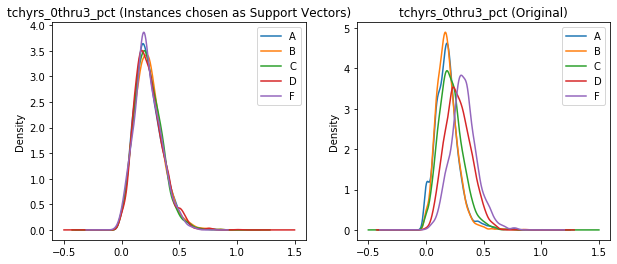

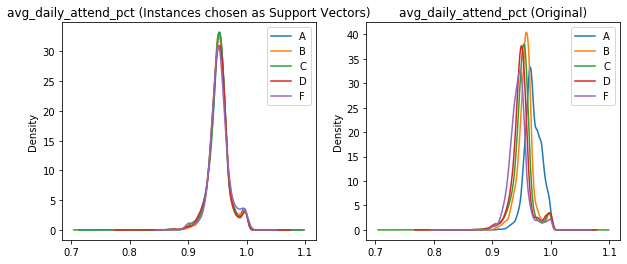

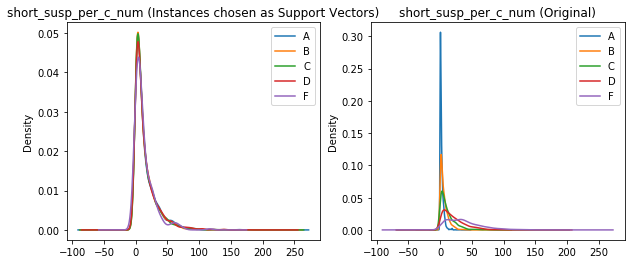

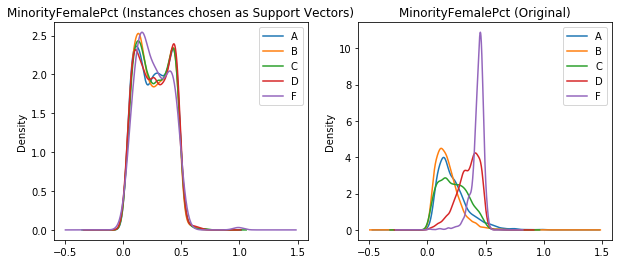

In [117]:
# now lets see the statistics of these attributes
#from pandas.tools.plotting import boxplot
from pandas.plotting import boxplot
from matplotlib import pyplot as plt

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['SPG Grade'])
#df_grouped = X_sub.groupby(['SPG Grade'])
df_grouped = schoolData_sm.groupby(['SPG Grade'])

# plot KDE of Different variables
###########This is a random selection NOW
vars_to_plot = ['tchyrs_0thru3_pct','avg_daily_attend_pct','short_susp_per_c_num','MinorityFemalePct']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['A','B','C','D','F'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['A','B','C','D','F'])
    plt.title(v+' (Original)')



### Logistic Regression

## Input Feature Importance

## Support Vectors Interpretation

## Model Advantages